# Setup

In [68]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split

import torchvision

import cv2
import numpy as np
import matplotlib.pyplot as plt

In [80]:
# define utility functions

def apply_field(img, field):
    """Applies specified deformation to an image."""
    img = img.numpy()
    print(img.shape)
    
    # set up adjusted coordinates
    _, _, h, w = img.shape
    x, y = np.meshgrid(np.arange(w), np.arange(h))
    coords = np.stack((x, y), axis=-1)
    coords_adj = coords + field

    # remap pixels
    img_adj = cv2.remap(img, coords_adj[:,:,0].astype(np.float32),
                        coords_adj[:,:,1].astype(np.float32), 
                        interpolation=cv2.INTER_LINEAR)
    
    img_adj = torch.Tensor(img_adj)
    return(img_adj)

def loss(img1, img2, field, lmbda):
    """Calculates loss associated with image reconstruction and associated field."""
    
    # approximate field gradient
    diff_x = torch.diff(field[:,:,0], axis=0)
    diff_y = torch.diff(field[:,:,1], axis=1)
    diff_x = F.pad(diff_x, (0, 0, 1, 0), mode='constant')
    diff_y = F.pad(diff_y, (1, 0, 0, 0), mode='constant')

    # calculate loss
    loss_sim = torch.sum((img1 - img2)**2)
    loss_smooth = torch.sum(diff_x**2 + diff_y**2)
    loss_total = loss_sim + lmbda * loss_smooth
    return(loss_total.item())

def show_images(img, img_adj, img_goal):
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 3, 1)
    plt.imshow(img)
    plt.title('Original Image')

    plt.subplot(1, 3, 2)
    plt.imshow(img_adj)
    plt.title('Estimated Image')

    plt.subplot(1, 3, 3)
    plt.imshow(img_goal)
    plt.title('Goal Image')

    plt.show()

In [81]:
# define model architecture

class DeformatioNet(nn.Module):
    def __init__(self):
        super(DeformatioNet, self).__init__()
        
        self.Encoder = nn.Sequential(
                nn.Conv2d(2, 16, 2, stride=2),
                nn.BatchNorm2d(16),
                nn.LeakyReLU(),
                nn.Dropout(0.5),
            )

        self.Decoder = nn.Sequential(
                nn.ConvTranspose2d(16, 2, 2, stride=2),
                nn.BatchNorm2d(2),
                nn.Tanh()
            )
    
    def forward(self, x, y):
        # stack images
        z = torch.cat((x,y),
                      dim=1)
        
        # encode images into latent space
        enc = self.Encoder(z)
        
        # decode latent space into deformation field
        field = self.Decoder(enc)*28 # multiply by 28 to fit image dimensions

        # (will use to adjust image in post)
        return(field)

# Model Training

In [52]:
field = model(img, img)

In [3]:
# set hyperparameters
batch_size = 1
lmbda = 0.01

In [4]:
transform = torchvision.transforms.ToTensor()

# load training data
train = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train.data = train.data[train.targets == 7]
train.targets = train.targets[train.targets == 7]

# split into training/validation sets
train, val = random_split(train, [int(0.8 * len(train)), len(train) - int(0.8 * len(train))])
train_loader = DataLoader(train, batch_size=batch_size, shuffle=True)
train_loader2 = DataLoader(train, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val, batch_size=batch_size, shuffle=True)
val_loader2 = DataLoader(val, batch_size=batch_size, shuffle=True)

# load test data
test = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
test.data = test.data[test.targets == 7]
test.targets = test.targets[test.targets == 7]
test_loader = DataLoader(test, batch_size=batch_size, shuffle=True)
test_loader2 = DataLoader(test, batch_size=batch_size, shuffle=True)

In [82]:
# training loop

def train_model(model, train_loader, train_loader2, lmbda, log_lr):
    
    # set optimizer
    optimizer = optim.Adam(model.parameters(), lr=10**log_lr, weight_decay=0)
    
    # run training loop
    for batch_id, (img, _) in enumerate(train_loader):
        print(f"Batch {batch_id+1} of {len(train_loader)}", end="\r")
        
        _, (img_goal, _) = next(enumerate(train_loader2))
        
        model.train()
        optimizer.zero_grad()

        field = model(img, img_goal)
        print(img.shape)
        print(field.shape)
        
        img_adj = apply_field(img, field)
        
        loss_train = loss(img_adj, img_goal, field, lmbda)
        loss_train.backward()
        optimizer.step()

    return model

model = DeformatioNet()
model = train_model(model, train_loader, train_loader2, 0.01, 0.001)

torch.Size([1, 1, 28, 28])
torch.Size([1, 2, 28, 28])
(1, 1, 28, 28)


TypeError: Concatenation operation is not implemented for NumPy arrays, use np.concatenate() instead. Please do not rely on this error; it may not be given on all Python implementations.

# Results

In [62]:
# generate random demo field
field = np.random.uniform(-1, 1, (28, 28, 2))

# set up demo images
img, _ = next(iter(train_loader))
img = img.squeeze()

img_goal, _ = next(iter(train_loader2))
img_goal = img_goal.squeeze()

# apply deformation field
field = model(img, img_goal).squeeze(0).detach().numpy()
field = np.transpose(field, (1,2,0))
img_adj = apply_field(img, field)

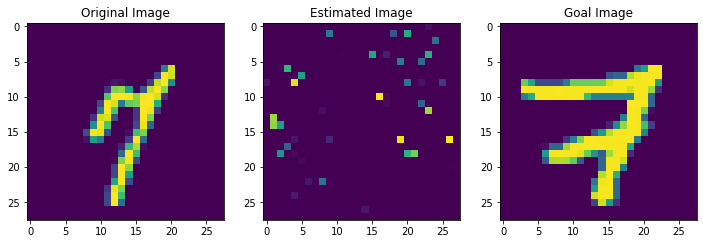

In [63]:
# display original/transformed images
show_images(img, img_adj, img_goal)

In [6]:
img1 = torch.Tensor(img)
img2 = torch.Tensor(img_adj)
field2 = torch.Tensor(field)

loss(img1, img2, field2, lmbda)

25.15184783935547